# Index
* [Modeling](#modeling)
    - [Prepare data](#prepare)
    - [Multivariate Adaptative Regression Splines (MARS)](#mars)
    - [K-Nearest Neighbohrs (KNN)](#knn)
    - [Suppor Vector Machines (SVM)](#svm)
    - [Random Forests](#RF)
    - [Artificial Neural Network (ANN)](#ann)
    

In [1]:
import tensorflow as tf
from tensorflow import keras

%load_ext autoreload
%autoreload 2

# Common libraries
import numpy as np
import pandas as pd
import os
import datetime as dt

from src.functions import data_import as dimp
from src.functions import data_exploration as dexp
from src.functions import data_transformation as dtr
from src.functions import metric

# Graphics
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly as pty
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.set_config_file(offline=True)

import re
from collections import OrderedDict

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")


c:\users\quark\.conda\envs\tfm-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\Quark\AppData\Roaming\Python\Python37\site-packages\botocore\vendored\requests\packages\urllib3\_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, MutableMapping


## Modeling
<a id="modeling"></a>

In [2]:
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from src.functions import metric
from sklearn.model_selection import cross_val_score
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model as lm
from pyearth import Earth
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import hdbscan
import plotly.graph_objects as go
from sklearn import linear_model, datasets
import scipy as sp
import mlflow
import mlflow.sklearn
from mlflow import log_metric, log_param, log_artifact
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from operational_analysis.toolkits import filters
from operational_analysis.toolkits import power_curve


import logging
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

c:\users\quark\.conda\envs\tfm-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

c:\users\quark\.conda\envs\tfm-env\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



### Prepare data
<a id="prepare"></a>

In [8]:
from kedro.io import DataCatalog
from kedro.extras.datasets.pandas import CSVDataSet
import pickle

In [4]:
X_train_WF1 = context.catalog.load("X_train_pped_WF1")

2020-09-13 11:33:25,284 - kedro.io.data_catalog - INFO - Loading data from `X_train_pped_WF1` (PickleDataSet)...


In [6]:
features_names_WF1 = context.catalog.load("feature_names_WF1")

2020-09-13 11:37:12,430 - kedro.io.data_catalog - INFO - Loading data from `feature_names_WF1` (PickleDataSet)...


In [7]:
features_names_WF1

Index(['CLCT', 'wspeed', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
       'wdir_sin', 'wdir_cos', 'inv_T', 'wspeed_wdir', 'wspeed_invT',
       'wspeed_wdir_invT'],
      dtype='object')

In [9]:
X_train = context.catalog.load("X_train_raw")
X_train["Time"] = pd.to_datetime(X_train["Time"], format="%d/%m/%Y %H:%M")
y_train = context.catalog.load("y_train_raw")

2020-09-13 12:57:41,763 - kedro.io.data_catalog - INFO - Loading data from `X_train_raw` (CSVDataSet)...
2020-09-13 12:57:42,196 - kedro.io.data_catalog - INFO - Loading data from `y_train_raw` (CSVDataSet)...


In [27]:
X_train.head()

,ID,WF,Time,NWP1_00h_D-2_U,NWP1_00h_D-2_V,NWP1_00h_D-2_T,NWP1_06h_D-2_U,NWP1_06h_D-2_V,NWP1_06h_D-2_T,NWP1_12h_D-2_U,...,NWP4_00h_D-1_CLCT,NWP4_12h_D-1_U,NWP4_12h_D-1_V,NWP4_12h_D-1_CLCT,NWP4_00h_D_U,NWP4_00h_D_V,NWP4_00h_D_CLCT,NWP4_12h_D_U,NWP4_12h_D_V,NWP4_12h_D_CLCT
0,1,WF1,2018-05-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.254603,-0.289687,82.543144,NaN,NaN,NaN
1,2,WF1,2018-05-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.490908,-0.413370,99.990844,NaN,NaN,NaN
2,3,WF1,2018-05-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.997093,-1.415138,98.367235,NaN,NaN,NaN
3,4,WF1,2018-05-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.689598,-0.961441,94.860604,NaN,NaN,NaN
4,5,WF1,2018-05-01 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.290994,-0.294963,95.905879,NaN,NaN,NaN


In [28]:
with open('../../data/04_feature/WF1/X_train_pped.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    train = pickle.load(f)

In [10]:
X = X_train.copy()
y = y_train.copy()

In [11]:
# Selecting rows by WF
X = X[X['WF'] == 'WF1']

# observations identifier
ID = X['ID']

# selecting rows of y_train and y_test
y = y['Production']
y = y.loc[ID.values - 1]

In [12]:
## Input missing values #####
new_cols = ['NWP1_U','NWP1_V','NWP1_T','NWP2_U',
            'NWP2_V','NWP3_U','NWP3_V','NWP3_T',
            'NWP4_U','NWP4_V','NWP4_CLCT']
        
dtr.add_new_cols(new_cols, X)

# Missing values inputation based on previous observations
cols = X_train.columns[3:]
X = dtr.input_missing_values(X, cols)

In [13]:
## Missing values inputation with interpolation (missings due to the provision frequency of each NWP)

col_list = ['NWP2_U','NWP2_V','NWP3_U','NWP3_V','NWP3_T']
X.index = X['Time']

del X['Time']
    
for var in col_list:
    X[var].interpolate(
        method='time', 
        inplace=True,
        limit=2,
        limit_direction='both'
    )


X.reset_index(inplace=True)

In [14]:
# Selecting the best data for each weather feature
X['U'] = (X.NWP1_U + X.NWP2_U + X.NWP3_U)/3
X['V'] = (X.NWP1_V + X.NWP2_V + X.NWP3_V )/3
X['T'] = (X.NWP1_T + X.NWP3_T)/2
X['CLCT'] = X.NWP4_CLCT

X = X[['ID','Time','U','V','T','CLCT']]
X['Production'] = y.to_list()

2020-09-13 12:57:50,896 - numexpr.utils - INFO - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2020-09-13 12:57:50,897 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


In [15]:
X.shape

(6239, 7)

In [16]:
def plot_flagged_pc(ws, p, flag_bool, alpha):
    plt.scatter(ws, p, s = 3, alpha = alpha)
    plt.scatter(ws[flag_bool], p[flag_bool], s = 3, c = 'red')
    plt.xlabel('Wind speed (m/s)')
    plt.ylabel('Power (MWh)')
    plt.show()

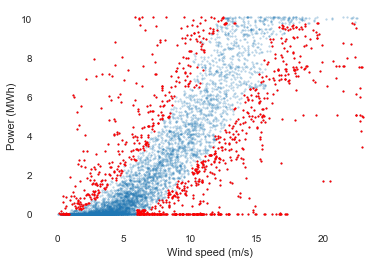

In [18]:
####### Cleaning outliers in the whole data set (train + test) ########
clean_outliers = True

if clean_outliers:
    # Power curve data
    X['Production'] = y.to_list()
    X['vel'] = X.apply(dtr.get_wind_speed, axis=1)
    X_ = X[['vel','Production']]
    
    # top-curve stacked outliers
    top_stacked = filters.window_range_flag(X_.Production, 0.97*X_.Production.max(), X_.Production.max(), X_.vel, 12.5, 2000.)

    # sparse outliers
    max_bin = 0.97*X_.Production.max()
    sparse_outliers = filters.bin_filter(X_.Production, X_.vel, 0.25, 0.85*X_.Production.std(), 'median', 0.2, max_bin, 'scalar', 'all')

    # bottom-curve stacked outliers
    bottom_stacked = filters.window_range_flag(X_.vel, 6.0, 40, X_.Production, 0.05, 2000.)
    
    plot_flagged_pc(X_.vel, X_.Production,(top_stacked) | (sparse_outliers) | (bottom_stacked), 0.3)

    # deleting outliers
    X_.vel = X_.vel[(~top_stacked) & (~sparse_outliers) & (~bottom_stacked)]
    X_.Production = X_.Production[(~top_stacked) & (~sparse_outliers) & (~bottom_stacked)]
    
    # Transform features
    # pt = PowerTransformer(method="yeo-johnson", standardize=True)
    # X['Production'] = pt.fit_transform(X['Production'].to_numpy().reshape(-1,1))
    # X['vel'] = pt.fit_transform(X['vel'].to_numpy().reshape(-1,1))
    # X_ = X[['vel','Production']]
    
    # select no-outliers observations 
    X = X.loc[X['vel'].isin(X_.vel)]
    del X['vel']
    
    # Fix abnormal values in CLCT
    X.loc[X['CLCT'] < 0, 'CLCT'] = 0.0
     

In [37]:
X.shape

(5247, 7)

In [19]:
## Split X in train and test sets

def split_data_by_date(date, X, y):
    """
    It splits X and y sets by a 'Time' value 
    into sets for training and testing. 
        - Return: a dictionary with the four sets
                  (X_train, y_train, X_test, y_test)
    """
    sets = {}
    date_cut = dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
    
    X_test = X[X['Time'] > date_cut]
    X_train = X[X['Time'] <= date_cut]
    y_train = y[X_train.index]
    y_test = y[X_test.index]
    
    sets['X_train'] = X_train
    sets['X_test'] = X_test
    sets['y_train'] = y_train
    sets['y_test'] = y_test
    
    return sets

train_test_dfs = split_data_by_date('2018-11-13 23:00:00', X, X['Production'])
X_train = train_test_dfs.get('X_train')
X_test = train_test_dfs.get('X_test')
y_train = train_test_dfs.get('y_train')
y_test = train_test_dfs.get('y_test')

In [20]:
del X_train['Production']
del X_test['Production']

In [21]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    cape = metric.get_cape(actual, pred)
    return rmse, mae, r2, cape

In [22]:
X_train_2 = X_train.copy()
X_test_2 = X_test.copy()
y_train_2 = y_train.copy()
y_test_2 = y_test.copy()

In [42]:
X_train_2.to_csv('../../data/pycaret_tests/X_train.csv', index=False)
X_test_2.to_csv('../../data/pycaret_tests/X_test.csv', index=False)
y_train_2.to_csv('../../data/pycaret_tests/y_train.csv', index=False, header=None)
y_test_2.to_csv('../../data/pycaret_tests/y_test.csv', index=False, header=None)

In [21]:
# for k_best in range(1,4):
    # print('------- k_best_features = {} ----------'.format(k_best))
    
## Feature engineering pipeline #####
feat_adder = dtr.NewFeaturesAdder(add_time_feat=True, add_cycl_feat=True, add_inv_T=False)

### Multiple Adaptative Regression Splines (MARS)
<a id="mars"></a>

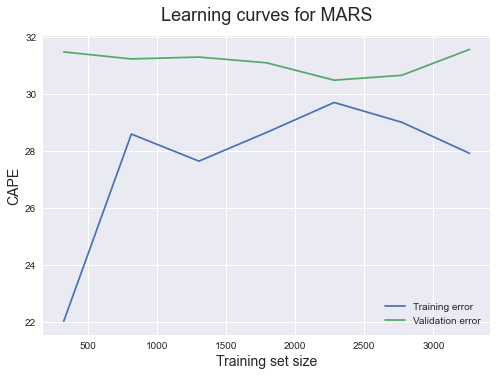

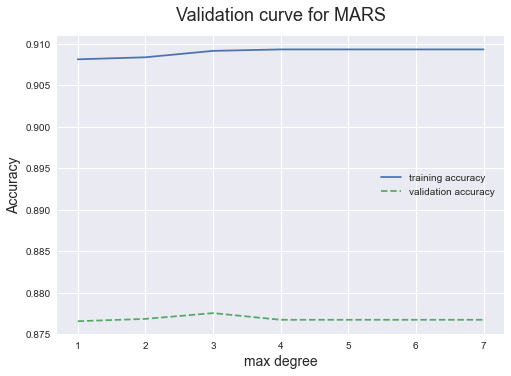

Best CV CAPE:30.94, std:3.86
Best CV MAE:0.52, std:0.19
Best CV R2:0.88, std:0.02
Best CV RMSE:0.81, std:0.23
Test CAPE:  21.980649029955096
Test R2:  0.9057222605203348
Test rmse:  1.0532424106510472


In [92]:
# for k_best in range(1,4):
    # print('------- k_best_features = {} ----------'.format(k_best))
    
## Feature engineering pipeline #####
feat_adder = dtr.NewFeaturesAdder(add_time_feat=True, add_cycl_feat=True, add_inv_T=False, add_interactions=True)

drop_lst = []
if feat_adder.get_params().get('add_cycl_feat'):
    if feat_adder.get_params().get('add_inv_T'):
        drop_lst = ["ID", "Time", "U", "V", "wdir", "hour", "month", "T"]
    else:
        drop_lst = ["ID", "Time", "U", "V", "wdir", "hour", "month"]
else:
    if feat_adder.get_params().get('add_inv_T'):
        drop_lst = ["ID", "Time", "U", "V", "T"]
    else:
        drop_lst = ["ID", "Time", "U", "V"]

pre_process = ColumnTransformer(remainder = 'passthrough',
                                transformers = [(
                                    'drop_columns', 'drop', drop_lst)
                                ])

# transforming target because of its skweed distribution.
tt = Pipeline(steps=[
    ('powertransformer', PowerTransformer(method='yeo-johnson', standardize=True)), 
])

feat_eng_pipeline = Pipeline(steps=[
    ('attr_adder', feat_adder), 
    ('pre_processing', pre_process),
    ('powertransformer', PowerTransformer(method='yeo-johnson', standardize=True)),   
])


X_train_pped = feat_eng_pipeline.fit_transform(X_train_2)
X_test_pped = feat_eng_pipeline.transform(X_test_2)

#### 
# Feature selection
feature_names = X_train_2.drop(drop_lst, axis=1).columns
selec_k_best = SelectKBest(mutual_info_regression, k=1)        

# make scorers
cape_scorer = make_scorer(metric.get_cape, greater_is_better=False)

pipeline = Pipeline([("univariate_sel", selec_k_best), ("mars", Earth(feature_importance_type='gcv'))])

## Modeling: MARS using py-earth ######
param_grid = {'mars__max_degree': [3,4,5], 
              'mars__allow_linear': [False, True], 
              'mars__penalty': [0.,1.,2.,3.,4.,5.,6.],
              'univariate_sel__k': list(range(1,3)),
              }

# Cross validation and hyper-parameter tunning with grid seach
scoring = {'RMSE': 'neg_root_mean_squared_error', 'MAE': 'neg_mean_absolute_error', 'R2':'r2' , 'CAPE': cape_scorer}
n_splits = 7
tscv = TimeSeriesSplit(n_splits)
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=tscv,
    scoring=scoring, refit='CAPE',
    n_jobs=-1
)
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
grid_search.fit(X_train_pped, y_train_2)

experiment_name = 'WF1: MARS'
mlflow.set_experiment(experiment_name)

with mlflow.start_run():
    
    # Feature selection with the best k value obtanined in Grid Search
    selec_k_best = SelectKBest(mutual_info_regression, k=grid_search.best_params_['univariate_sel__k'])
    selec_k_best.fit(X_train_pped, y_train_2)
    X_train_pped = selec_k_best.transform(X_train_pped)
    X_test_pped = selec_k_best.transform(X_test_pped)
    
    mask =selec_k_best.get_support() #list of booleans
    selected_feat = [] 

    for bool, feature in zip(mask, feature_names):
        if bool:
            selected_feat.append(feature)  

        # Re-training without CV, using the best parameters obtained by CV
        mars = Earth(max_degree=grid_search.best_params_['mars__max_degree'],
                 allow_linear=grid_search.best_params_['mars__allow_linear'],
                 penalty=grid_search.best_params_['mars__penalty']
                )

    mars_ttreg = TransformedTargetRegressor(regressor=mars, 
                                   transformer=tt, 
                                   check_inverse=False)
    mars_ttreg.fit(X_train_pped, y_train_2)


    # learning curves
    train_sizes = np.linspace(0.1, 1.0, 7)
    train_sizes, train_scores, validation_scores = learning_curve(estimator = mars,
                                                                  X = X_train_pped,
                                                                  y = y_train_2, scoring=cape_scorer, 
                                                                  train_sizes = train_sizes)

    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)

    plt.style.use('seaborn')
    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
    plt.ylabel('CAPE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title('Learning curves for MARS', fontsize = 18, y = 1.03)
    plt.legend()
    plt.show()
    plt.close()

    # Validation curves
    param_range = [1,2,3,4,5,6,7]
    train_scores, test_scores = validation_curve(Earth(allow_linear=grid_search.best_params_["mars__allow_linear"],
                                                        penalty=grid_search.best_params_["mars__penalty"],
                                                        feature_importance_type='gcv'),
                                                  X_train_pped, y_train_2, "max_degree",param_range, cv=5)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.style.use('seaborn')
    plt.plot(param_range, train_mean, label="training accuracy")
    plt.plot(param_range, test_mean, linestyle="--", label="validation accuracy")
    plt.ylabel('Accuracy', fontsize = 14)
    plt.xlabel('max degree', fontsize = 14)
    plt.title('Validation curve for MARS', fontsize = 18, y = 1.03)
    plt.legend()
    plt.show()
    plt.close()

    # predicting on test data
    predictions = mars_ttreg.predict(X_test_pped)

    # build prediction matrix (ID,Production)
    pred_matrix = np.stack((np.array(y_test_2.index.to_series()).astype(int), predictions), axis=-1)
    df_pred = pd.DataFrame(data=pred_matrix.reshape(-1,2), columns=['ID','Production'])

    # print score
    results = grid_search.cv_results_
    for scorer in sorted(scoring):
        best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
        best_CV = results['mean_test_%s' % scorer][best_index]
        best_CV_std = results['std_test_%s' % scorer][best_index]
        
        if (scorer=='RMSE') or (scorer=='MAE') or (scorer=='CAPE'):
            print('Best CV {0}:{1:.2f}, std:{2:.2f}'.format(scorer,-best_CV,best_CV_std))
        else:
            print('Best CV {0}:{1:.2f}, std:{2:.2f}'.format(scorer,best_CV,best_CV_std))           
     
    print('Test CAPE: ', metric.get_cape(y_test_2, predictions))
    print('Test R2: ', r2_score(y_test_2, predictions))
    print('Test rmse: ', np.sqrt(mean_squared_error(y_test_2, predictions)))

    ### MLFlow logging ####
    (rmse, mae, r2, cape) = eval_metrics(y_test_2, predictions)
    mlflow.set_tag("grid_searh_best_params", grid_search.best_params_)

    # pre-processing
    mlflow.log_param("clean_outliers", clean_outliers)
    # mlflow.log_param("feature_selection", feature_sel)
    mlflow.log_param("selected_features", selected_feat)
    mlflow.log_param("k_best_features", param_grid.get("univariate_sel__k"))

    # grid search parameters
    mlflow.log_param("max_degree", param_grid.get("mars__max_degree"))
    mlflow.log_param("penalty", param_grid.get("mars__penalty"))
    mlflow.log_param("allow_linear", param_grid.get("mars__allow_linear"))
    mlflow.log_param("CV_splits", n_splits)

    # metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("cape", cape)

    # artifacts
    mlflow.sklearn.log_model(mars_ttreg, "mars")
    # mlflow.log_artifact()

In [104]:
print(grid_search.best_params_)

{'mars__allow_linear': True, 'mars__max_degree': 4, 'mars__penalty': 4.0, 'univariate_sel__k': 1}


In [103]:
grid_search.best_estimator_

Pipeline(steps=[('univariate_sel',
                 SelectKBest(k=1,
                             score_func=<function mutual_info_regression at 0x000002CF48514950>)),
                ('mars',
                 Earth(allow_linear=True, feature_importance_type='gcv',
                       max_degree=4, penalty=4.0))])

In [41]:
real_pred = np.concatenate((np.array(y_test), predictions)).reshape(len(y_test),2)

df_real_pred =  pd.DataFrame(data=real_pred,
                             index=X_test.Time,
                             columns=['real-production','pred-production'])

df_real_pred.iplot(kind='scatter', filename='cufflinks/cf-simple-line')

In [99]:
y_train_2

0       0.02
1       0.07
2       0.22
3       0.39
4       0.41
        ... 
4721    0.00
4722    0.00
4723    0.00
4724    0.00
4725    0.00
Name: Production, Length: 4077, dtype: float64

### K - Nearest Neighbohrs (KNN)
<a id="knn"></a>

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

X_train_2 = X_train.copy()
X_test_2 = X_test.copy()
y_train_2 = y_train.copy()
y_test_2 = y_test.copy()

In [ ]:
for k_best_features in range(1,7):
    print('------- k_best_features = {} ----------'.format(k_best_features))
    
    ## Pre-process pipeline #####
    drop_lst = ['ID','Time','U','V']
    pre_process = ColumnTransformer(remainder = 'passthrough',
                                    transformers = [(
                                        'drop_columns', 'drop', drop_lst)
                                    ])

    tt = Pipeline(steps=[
        #('powertransformer', PowerTransformer(method='yeo-johnson', standardize=True)),
        ('normalization', MinMaxScaler(feature_range=(0, 1))) 
    ])

    prepare_data_pipeline = Pipeline(steps=[
        ('attr_adder', dtr.NewFeaturesAdder(add_time_feat=True, add_cycl_feat=False, add_inv_T=False)), 
        ('pre_processing', pre_process),
        ('powertransformer', PowerTransformer(method='yeo-johnson', standardize=True)),
        #('normalization', MinMaxScaler(feature_range=(0, 1)))    
    ])

    X_train_pped = prepare_data_pipeline.fit_transform(X_train_2)
    X_test_pped = prepare_data_pipeline.transform(X_test_2)

    feature_sel = True
    feature_names = X_train_2.drop(drop_lst, axis=1).columns

    # Feature selection 
    if feature_sel: 
        ## using Mutual Information
        selec_k_best = SelectKBest(mutual_info_regression, k=k_best_features)
        selec_k_best.fit(X_train_pped, y_train_2)
        X_train_pped = selec_k_best.transform(X_train_pped)
        X_test_pped = selec_k_best.transform(X_test_pped)

        mask =selec_k_best.get_support() #list of booleans
        selected_feat = [] 

        for bool, feature in zip(mask, feature_names):
            if bool:
                selected_feat.append(feature)          

    # make scorers
    cape_scorer = make_scorer(metric.get_cape, greater_is_better=False)

    # KNN model
    param_grid = {
        'n_neighbors': list(range(1,50,2)),
        'algorithm':['auto', 'kd_tree'],
        'weights': ['uniform','distance'],
        'metric': ['cityblock','mahalanobis','euclidean'],
        'p': [1,2]
    }

    n_splits=6
    tscv = TimeSeriesSplit(n_splits)
    knn_reg = KNeighborsRegressor()
    grid_search_knn = GridSearchCV(
        knn_reg, 
        param_grid, 
        cv= tscv,
        n_jobs=-1,
        scoring=cape_scorer
    )

    grid_search_knn.fit(X_train_pped, y_train_2)

    experiment_name = 'WF1: KNN'
    mlflow.set_experiment(experiment_name)

    with mlflow.start_run():
        # Re-train the model with the best parameters found in CV 
        knn_reg2 = KNeighborsRegressor(algorithm=grid_search_knn.best_params_['algorithm'],
                                       n_neighbors=grid_search_knn.best_params_['n_neighbors'],
                                       p=grid_search_knn.best_params_['p'], 
                                       weights=grid_search_knn.best_params_['weights'],
                                       metric=grid_search_knn.best_params_['metric'])

        ttreg = TransformedTargetRegressor(regressor=knn_reg2, 
                                         transformer=tt, 
                                         check_inverse=False)

        ttreg.fit(X_train_pped, y_train_2)
        #knn_reg2.fit(X_train_pped, y_train)

        # learning curves
        train_sizes = np.linspace(0.1, 1.0, 7)
        train_sizes, train_scores, validation_scores = learning_curve(estimator = ttreg,
                                                                      X = X_train_pped,
                                                                      y = y_train_2, 
                                                                      train_sizes = train_sizes,
                                                                      scoring=cape_scorer
                                                                     )

        train_scores_mean = -train_scores.mean(axis = 1)
        validation_scores_mean = -validation_scores.mean(axis = 1)

        plt.style.use('seaborn')
        plt.plot(train_sizes, train_scores_mean, label = 'Training error')
        plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
        plt.ylabel('CAPE', fontsize = 14)
        plt.xlabel('Training set size', fontsize = 14)
        plt.title('Learning curves for KNN', fontsize = 18, y = 1.03)
        plt.legend()
        plt.show()
        plt.close()

        # Validation curves
        param_range = list(range(1,30,2))
        train_scores, test_scores = validation_curve(KNeighborsRegressor(algorithm=grid_search_knn.best_params_['algorithm'],
                                                                         p=grid_search_knn.best_params_['p'], 
                                                                         weights=grid_search_knn.best_params_['weights'],
                                                                         metric=grid_search_knn.best_params_['metric']),
                                                      X_train_pped, y_train_2, "n_neighbors",param_range, cv=5)

        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)

        plt.style.use('seaborn')
        plt.plot(param_range, train_mean, label="training accuracy")
        plt.plot(param_range, test_mean, linestyle="--", label="validation accuracy")
        plt.ylabel('Accuracy', fontsize = 14)
        plt.xlabel('nº neighbors', fontsize = 14)
        plt.title('Validation curve for KNN', fontsize = 18, y = 1.03)
        plt.legend()
        plt.show()
        plt.close()

        # Testing
        predictions = ttreg.predict(X_test_pped)

        # Building prediction matrix (ID,Production)
        pred_matrix = np.stack((np.array(y_test.index.to_series()).astype(int), predictions), axis=-1)
        df_pred = pd.DataFrame(data=pred_matrix.reshape(-1,2), columns=['ID','Production'])

        print('Best CV score:', -grid_search_knn.best_score_)
        print('Test CAPE: ', metric.get_cape(y_test, predictions))
        print('Test rmse: ', np.sqrt(mean_squared_error(y_test, predictions)))
        print('Test R2: ', r2_score(y_test, predictions))

        ### MLFlow logging ####
        (rmse, mae, r2, cape) = eval_metrics(y_test_2, predictions)

        mlflow.set_tag("grid_searh_best_params", grid_search_knn.best_params_)

        # pre-processing
        mlflow.log_param("clean_outliers", clean_outliers)
        mlflow.log_param("feature_selection", feature_sel)
        mlflow.log_param("selected_features", selected_feat)
        mlflow.log_param("k_best_features", k_best_features)

        # grid search parameters
        mlflow.log_param("n_neighbors", param_grid.get("n_neighbors"))
        mlflow.log_param("algorithm", param_grid.get("algorithm"))
        mlflow.log_param("weights", param_grid.get("weights"))
        mlflow.log_param("metric", param_grid.get("metric"))
        mlflow.log_param("CV_splits", n_splits)

        # metrics
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("cape", cape)

        # artifacts
        mlflow.sklearn.log_model(ttreg, "knn")
        # mlflow.log_artifact()

In [ ]:
selected_feat

In [ ]:
real_pred = np.concatenate((predictions, np.array(y_test))).reshape(len(y_test),2)
df_real_pred =  pd.DataFrame(data=real_pred,
                             index=X_test.Time,
                             columns=['pred-production','real-production'])
df_real_pred.iplot(kind='scatter', filename='cufflinks/cf-simple-line')

### Support Vector Machine (SVM)
<a id="svm"></a>

In [ ]:
from sklearn.svm import SVR

In [ ]:
X_train_2 = X_train.copy()
X_test_2 = X_test.copy()
y_train_2 = y_train.copy()
y_test_2 = y_test.copy()

In [ ]:
## Pre-process pipeline #####
for k_best_features in range(1,10):
    print('------- k_best_features = {} ------'.format(k_best_features))
    drop_lst = ['ID','Time','U','V']
    pre_process = ColumnTransformer(remainder = 'passthrough',
                                    transformers = [(
                                        'drop_columns', 'drop', drop_lst)
                                    ])

    tt = Pipeline(steps=[
        ('powertransformer', PowerTransformer(method='yeo-johnson', standardize=True)),
        # ('normalization', MinMaxScaler(feature_range=(0, 1))) 
        # ('standard_scaler', StandardScaler())
    ])

    prepare_data_pipeline = Pipeline(steps=[
        ('attr_adder', dtr.NewFeaturesAdder(add_time_feat=True, add_cycl_feat=False, add_inv_T=False)), 
        ('pre_processing', pre_process),
        ('powertransformer', PowerTransformer(method='yeo-johnson', standardize=True)),
        # ('normalization', MinMaxScaler(feature_range=(0, 1)),
        # ('standard_scaler', StandardScaler())    
    ])

    X_train_pped = prepare_data_pipeline.fit_transform(X_train_2)
    X_test_pped = prepare_data_pipeline.transform(X_test_2)

    feature_sel = True
    feature_names = X_train_2.drop(drop_lst, axis=1).columns

    # Feature selection 
    if feature_sel: 
        ## using Mutual Information
        selec_k_best = SelectKBest(mutual_info_regression, k=k_best_features)
        selec_k_best.fit(X_train_pped, y_train_2)
        X_train_pped = selec_k_best.transform(X_train_pped)
        X_test_pped = selec_k_best.transform(X_test_pped)

        mask =selec_k_best.get_support() #list of booleans
        selected_feat = [] 

        for bool, feature in zip(mask, feature_names):
            if bool:
                selected_feat.append(feature)  

    # make scorers
    cape_scorer = make_scorer(metric.get_cape, greater_is_better=False)

    param_grid = {
        'kernel': ('linear', 'rbf','poly'), 
        'C':[0.01, 1, 0.1, 10, 100],
        'gamma': [0.00001, 0.001, 1],
        'epsilon':[0.1,0.3,0.5]
    }

    svm_reg = SVR()
    n_splits=9
    grid_search_svm = GridSearchCV(
        svm_reg, 
        param_grid, 
        cv= TimeSeriesSplit(n_splits),
        scoring=cape_scorer,
        n_jobs=-1
    )

    grid_search_svm.fit(X_train_pped, y_train_2)

    experiment_name = 'WF1: SVM'
    mlflow.set_experiment(experiment_name)

    with mlflow.start_run():
        svm_reg2 = SVR(kernel = grid_search_svm.best_params_['kernel'],
                       C = grid_search_svm.best_params_['C'],
                       gamma = grid_search_svm.best_params_['gamma'],
                       epsilon = 0.1)

        ttreg = TransformedTargetRegressor(regressor=svm_reg2, transformer=tt, check_inverse=False)

        ttreg.fit(X_train_pped, y_train_2)
        # svm_reg2.fit(X_train_pped, y_train_2)

        # learning curves
        train_size = np.linspace(0.1, 1.0, 7)
        train_sizes, train_scores, validation_scores = learning_curve(estimator = ttreg,
                                                                      X = X_train_pped,
                                                                      y = y_train_2, 
                                                                      train_sizes = train_size,
                                                                      scoring = cape_scorer)

        train_scores_mean = -train_scores.mean(axis = 1)
        validation_scores_mean = -validation_scores.mean(axis = 1)

        plt.style.use('seaborn')
        plt.plot(train_sizes, train_scores_mean, label = 'Training error')
        plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
        plt.ylabel('CAPE', fontsize = 14)
        plt.xlabel('Training set size', fontsize = 14)
        plt.title('Learning curves for SVM', fontsize = 18, y = 1.03)
        plt.legend()
        plt.show()
        plt.close()

        # Validation curves
        param_range = list(range(0,30,2))
        train_scores, test_scores = validation_curve(SVR(kernel = grid_search_svm.best_params_['kernel'],
                                                         gamma = grid_search_svm.best_params_['gamma'],
                                                         epsilon = grid_search_svm.best_params_['epsilon']),
                                                     X_train_pped, y_train_2, "C",param_range, cv=5)

        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)

        plt.style.use('seaborn')
        plt.plot(param_range, train_mean, label="training accuracy")
        plt.plot(param_range, test_mean, linestyle="--", label="validation accuracy")
        plt.ylabel('Accuracy', fontsize = 14)
        plt.xlabel('C', fontsize = 14)
        plt.title('Validation curve for SVM', fontsize = 18, y = 1.03)
        plt.legend()
        plt.show()
        plt.close()

        # Testing
        predictions = ttreg.predict(X_test_pped)
        #predictions = svm_reg2.predict(X_test_pped)

        # Building prediction matrix (ID,Production)
        pred_matrix = np.stack((np.array(y_test_2.index.to_series()).astype(int), predictions), axis=-1)
        df_pred = pd.DataFrame(data=pred_matrix.reshape(-1,2), columns=['ID','Production'])

        print('Best CV score:', -grid_search_svm.best_score_)
        print('Test CAPE: ', metric.get_cape(y_test_2, predictions))
        print('Test rmse: ', np.sqrt(mean_squared_error(y_test_2, predictions)))
        print('Test R2: ', r2_score(y_test_2, predictions))

        ### MLFlow logging ####
        (rmse, mae, r2, cape) = eval_metrics(y_test_2, predictions)

        mlflow.set_tag("grid_searh_best_params", grid_search_svm.best_params_)

        # pre-processing
        mlflow.log_param("clean_outliers", clean_outliers)
        mlflow.log_param("feature_selection", feature_sel)
        mlflow.log_param("selected_features", selected_feat)
        mlflow.log_param("k_best_features", k_best_features)

        # grid search parameters
        mlflow.log_param("kernel", param_grid.get("kernel"))
        mlflow.log_param("C", param_grid.get("C"))
        mlflow.log_param("gamma", param_grid.get("gamma"))
        mlflow.log_param("epsilon", param_grid.get("epsilon"))
        mlflow.log_param("CV_splits", n_splits)

        # metrics
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("cape", cape)

        # artifacts
        mlflow.sklearn.log_model(ttreg, "svm")
        # mlflow.log_artifact()

### Random Forests
<a id="RF"></a>

In [44]:
X_train_2 = X_train.copy()
X_test_2 = X_test.copy()
y_train_2 = y_train.copy()
y_test_2 = y_test.copy()

In [ ]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

for k_best_features in range(1,10):
    print('------- k_best_features = {} ------'.format(k_best_features))
    
    drop_lst = ['ID','Time','U','V','month','hour','w_dir']
    pre_process = ColumnTransformer(remainder = 'passthrough',
                                    transformers = [(
                                        'drop_columns', 'drop', drop_lst)
                                    ])
    
    # tt = Pipeline(steps=[
    #     ('powertransformer', PowerTransformer(method='yeo-johnson', standardize=True)),
    #     ('normalization', MinMaxScaler(feature_range=(0, 1))),
    #     ('standard_scaler', StandardScaler())
    # ])
    
    prepare_data_pipeline = Pipeline(steps=[
        ('attr_adder', dtr.NewFeaturesAdder(add_time_feat=True, add_cycl_feat=True, add_inv_T=False)), 
        ('pre_processing', pre_process)
        # ('powertransformer', PowerTransformer(method='yeo-johnson', standardize=True)),
        # ('normalization', MinMaxScaler(feature_range=(0, 1)),
        # ('standard_scaler', StandardScaler())    
    ])
    
    X_train_pped = prepare_data_pipeline.fit_transform(X_train_2)
    X_test_pped = prepare_data_pipeline.transform(X_test_2)
    
    feature_sel = True
    feature_names = X_train_2.drop(drop_lst, axis=1).columns
    
    # Feature selection 
    if feature_sel: 
        ## using Mutual Information
        selec_k_best = SelectKBest(mutual_info_regression, k=k_best_features)
        selec_k_best.fit(X_train_pped, y_train_2)
        X_train_pped = selec_k_best.transform(X_train_pped)
        X_test_pped = selec_k_best.transform(X_test_pped)
    
        mask =selec_k_best.get_support() #list of booleans
        selected_feat = [] 
    
        for bool, feature in zip(mask, feature_names):
            if bool:
                selected_feat.append(feature)  
    
    # make scorers
    cape_scorer = make_scorer(metric.get_cape, greater_is_better=False)
    
    # hyperparameters
    # n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
    # max_features = ['auto', 'sqrt']
    # m# ax_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
    # max_depth.append(None)
    # min_samples_split = [5, 10, 15, 20]
    # min_samples_leaf = [1, 2, 4]
    # bootstrap = [True, False]
    
    # Create the random grid
    # random_grid = {'n_estimators': n_estimators,
    #                'max_features': max_features,
    #                'max_depth': max_depth,
    #                'min_samples_split': min_samples_split,
    #                'min_samples_leaf': min_samples_leaf,
    #                'bootstrap': bootstrap}
    # 
    # Use the random grid to search for best hyperparameters ranges
    # rf = RandomForestRegressor()
    # rf_random = RandomizedSearchCV(estimator = rf, 
    #                                param_distributions = random_grid, 
    #                                n_iter = 100, cv = 3,
    #                                random_state=42, 
    #                                n_jobs = -1)
    # 
    # rf_random.fit(X_train_pped, y_train_2)
    # print(rf_random.best_params_)
    
    param_grid = {
        'n_estimators': [75, 150, 225],
        'max_features': ['sqrt', 'log2', 'auto'],
        'max_depth': [10, 50, 100],
        'min_samples_split': [15, 30, 45],
        'min_samples_leaf': [4, 6, 8],
    }
    
    
    n_splits = 7 
    forest_reg = RandomForestRegressor(bootstrap=True, random_state=42)
    grid_search = GridSearchCV(
        forest_reg, 
        param_grid, 
        cv=TimeSeriesSplit(n_splits),
        scoring=cape_scorer,
        n_jobs=-1
    )
    
    grid_search.fit(X_train_pped, y_train_2)
    
    experiment_name = 'WF1: Ranfom Forest'
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run():
        forest_reg2 = RandomForestRegressor(
            n_estimators=grid_search.best_params_['n_estimators'],
            max_features=grid_search.best_params_['max_features'],
            max_depth=grid_search.best_params_['max_depth'],
            min_samples_split=grid_search.best_params_['min_samples_split'],
            min_samples_leaf=grid_search.best_params_['min_samples_leaf']
            
        )
    
        # ttreg = TransformedTargetRegressor(regressor=forest_reg2, transformer=tt, check_inverse=False)
    
        # ttreg.fit(X_train_pped, y_train_2)
        forest_reg2.fit(X_train_pped, y_train_2)
    
        # learning curves
        train_size = np.linspace(0.1, 1.0, 7)
        train_sizes, train_scores, validation_scores = learning_curve(estimator = forest_reg2,
                                                                      X = X_train_pped,
                                                                      y = y_train_2, 
                                                                      train_sizes = train_size,
                                                                      scoring = cape_scorer)
    
        train_scores_mean = -train_scores.mean(axis = 1)
        validation_scores_mean = -validation_scores.mean(axis = 1)
    
        plt.style.use('seaborn')
        plt.plot(train_sizes, train_scores_mean, label = 'Training error')
        plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
        plt.ylabel('CAPE', fontsize = 14)
        plt.xlabel('Training set size', fontsize = 14)
        plt.title('Learning curves for RF', fontsize = 18, y = 1.03)
        plt.legend()
        plt.show()
        plt.close()
    
        # Validation curves
        #param_range = list(range(1,400,10))
        #train_scores, test_scores = validation_curve(RandomForestRegressor(
        #    max_features=grid_search.best_params_['max_features'],
        #    max_depth=grid_search.best_params_['max_depth'],
        #    min_samples_split=grid_search.best_params_['min_samples_split'],
        #    min_samples_leaf=grid_search.best_params_['min_samples_leaf']
        #), X_train_pped, y_train, "n_estimators",param_range, cv=TimeSeriesSplit(n_splits))
    #
        #train_mean = np.mean(train_scores, axis=1)
        #train_std = np.std(train_scores, axis=1)
        #test_mean = np.mean(test_scores, axis=1)
        #test_std = np.std(test_scores, axis=1)
    #
        #plt.style.use('seaborn')
        #plt.plot(param_range, train_mean, label="training accuracy")
        #plt.plot(param_range, test_mean, linestyle="--", label="validation accuracy")
        #plt.ylabel('Accuracy', fontsize = 14)
        #plt.xlabel('# estimators', fontsize = 14)
        #plt.title('Validation curve for RF', fontsize = 18, y = 1.03)
        #plt.legend()
        #plt.show()
        #plt.close()
    
        # Testing
        # predictions = ttreg.predict(X_test_pped)
        predictions = forest_reg2.predict(X_test_pped)
    
        # Building prediction matrix (ID,Production)
        pred_matrix = np.stack((np.array(y_test_2.index.to_series()).astype(int), predictions), axis=-1)
        df_pred = pd.DataFrame(data=pred_matrix.reshape(-1,2), columns=['ID','Production'])
    
        print('Best CV score:', -grid_search.best_score_)
        print('Test CAPE: ', metric.get_cape(y_test_2, predictions))
        print('Test rmse: ', np.sqrt(mean_squared_error(y_test_2, predictions)))
        print('Test R2: ', r2_score(y_test_2, predictions))
    
        ### MLFlow logging ####
        (rmse, mae, r2, cape) = eval_metrics(y_test_2, predictions)
    
        mlflow.set_tag("grid_searh_best_params", grid_search.best_params_)
    
        # pre-processing
        mlflow.log_param("clean_outliers", clean_outliers)
        mlflow.log_param("feature_selection", feature_sel)
    
        if feature_sel:
            mlflow.log_param("k_best_features", k_best_features)
            mlflow.log_param("selected_features", selected_feat)
    
        # grid search parameters
        mlflow.log_param("n_estimators", param_grid.get("n_estimators"))
        mlflow.log_param("max_features", param_grid.get("max_features"))
        mlflow.log_param("max_depth", param_grid.get("max_depth"))
        mlflow.log_param("min_samples_leaf", param_grid.get("min_samples_leaf"))
        mlflow.log_param("min_samples_split", param_grid.get("min_samples_split"))
    
    
        # metrics
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("cape", cape)
    
        # artifacts
        mlflow.sklearn.log_model(forest_reg2, "RF")
        # mlflow.log_artifact()
    

In [ ]:
selected_feat

### Artificial Neural Network (ANN)
<a id="ann"></a>

In [262]:
X_train_2 = X_train.copy()
X_test_2 = X_test.copy()
y_train_2 = y_train.copy()
y_test_2 = y_test.copy()

In [263]:
from sklearn.model_selection import train_test_split

In [264]:
def build_model(n_hidden=1, n_neurons = 30, learning_rate = 3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
        
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr = learning_rate)
    model.compile(loss = "mse", optimizer = optimizer)
    
    return model
        

------- k_best_features = 1 ------
Train on 3652 samples, validate on 161 samples
Epoch 1/100
3652/3652 [==============================] - 0s 110us/sample - loss: 4.5274 - val_loss: 8.2360
Epoch 2/100
3652/3652 [==============================] - 0s 35us/sample - loss: 0.8436 - val_loss: 4.9489
Epoch 3/100
3652/3652 [==============================] - 0s 34us/sample - loss: 0.6285 - val_loss: 4.0164
Epoch 4/100
3652/3652 [==============================] - 0s 36us/sample - loss: 0.6057 - val_loss: 2.8495
Epoch 5/100
3652/3652 [==============================] - 0s 34us/sample - loss: 0.5963 - val_loss: 2.7595
Epoch 6/100
3652/3652 [==============================] - 0s 35us/sample - loss: 0.5863 - val_loss: 3.1923
Epoch 7/100
3652/3652 [==============================] - 0s 35us/sample - loss: 0.5852 - val_loss: 2.0429
Epoch 8/100
3652/3652 [==============================] - 0s 34us/sample - loss: 0.5746 - val_loss: 3.3113
Epoch 9/100
3652/3652 [==============================] - 0s 35us/samp

Test CAPE:  18.954719932054417
Test rmse:  0.9180757265165725
Test R2:  0.9305839658156021
------- k_best_features = 2 ------
Train on 3652 samples, validate on 161 samples
Epoch 1/100
3652/3652 [==============================] - 0s 84us/sample - loss: 0.8721 - val_loss: 4.6124
Epoch 2/100
3652/3652 [==============================] - 0s 27us/sample - loss: 0.5776 - val_loss: 1.4551
Epoch 3/100
3652/3652 [==============================] - 0s 29us/sample - loss: 0.5825 - val_loss: 4.8868
Epoch 4/100
3652/3652 [==============================] - 0s 29us/sample - loss: 0.5415 - val_loss: 2.9967
Epoch 5/100
3652/3652 [==============================] - 0s 35us/sample - loss: 0.5360 - val_loss: 1.3105
Epoch 6/100
3652/3652 [==============================] - 0s 32us/sample - loss: 0.5387 - val_loss: 1.1141
Epoch 7/100
3652/3652 [==============================] - 0s 31us/sample - loss: 0.5266 - val_loss: 1.7089
Epoch 8/100
3652/3652 [==============================] - 0s 29us/sample - loss: 0.524

Test CAPE:  26.54982370061225
Test rmse:  1.327658091753539
Test R2:  0.8548305331739054
------- k_best_features = 3 ------
Train on 3652 samples, validate on 161 samples
Epoch 1/100
3652/3652 [==============================] - 1s 165us/sample - loss: 1.1683 - val_loss: 1.4636
Epoch 2/100
3652/3652 [==============================] - 0s 30us/sample - loss: 0.6263 - val_loss: 1.7759
Epoch 3/100
3652/3652 [==============================] - 0s 30us/sample - loss: 0.5762 - val_loss: 2.2658
Epoch 4/100
3652/3652 [==============================] - 0s 29us/sample - loss: 0.6278 - val_loss: 1.0842
Epoch 5/100
3652/3652 [==============================] - 0s 30us/sample - loss: 0.6060 - val_loss: 1.1999
Epoch 6/100
3652/3652 [==============================] - 0s 29us/sample - loss: 0.5525 - val_loss: 1.0647
Epoch 7/100
3652/3652 [==============================] - 0s 30us/sample - loss: 0.5869 - val_loss: 2.9422
Epoch 8/100
3652/3652 [==============================] - 0s 28us/sample - loss: 0.5716

Test CAPE:  20.181901029719967
Test rmse:  0.9787305030463052
Test R2:  0.9211087139577382
------- k_best_features = 4 ------


C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Train on 3652 samples, validate on 161 samples
Epoch 1/100
3652/3652 [==============================] - 0s 94us/sample - loss: 4.1583 - val_loss: 18.8559
Epoch 2/100
3652/3652 [==============================] - 0s 30us/sample - loss: 1.0896 - val_loss: 5.2223
Epoch 3/100
3652/3652 [==============================] - 0s 29us/sample - loss: 0.6136 - val_loss: 3.0979
Epoch 4/100
3652/3652 [==============================] - 0s 29us/sample - loss: 0.5432 - val_loss: 2.2969
Epoch 5/100
3652/3652 [==============================] - 0s 29us/sample - loss: 0.5207 - val_loss: 1.4465
Epoch 6/100
3652/3652 [==============================] - 0s 28us/sample - loss: 0.5114 - val_loss: 1.7040
Epoch 7/100
3652/3652 [==============================] - 0s 29us/sample - loss: 0.5012 - val_loss: 1.8678
Epoch 8/100
3652/3652 [==============================] - 0s 28us/sample - loss: 0.4947 - val_loss: 1.7418
Epoch 9/100
3652/3652 [==============================] - 0s 30us/sample - loss: 0.4897 - val_loss: 1.518

Test CAPE:  19.001472818008054
Test rmse:  0.923573060170478
Test R2:  0.9297501661890573
------- k_best_features = 5 ------
Train on 3652 samples, validate on 161 samples
Epoch 1/100
3652/3652 [==============================] - 1s 159us/sample - loss: 1.0443 - val_loss: 1.2781
Epoch 2/100
3652/3652 [==============================] - 0s 34us/sample - loss: 0.6818 - val_loss: 1.8749
Epoch 3/100
3652/3652 [==============================] - 0s 34us/sample - loss: 0.6091 - val_loss: 1.5358
Epoch 4/100
3652/3652 [==============================] - 0s 35us/sample - loss: 0.5639 - val_loss: 2.4167
Epoch 5/100
3652/3652 [==============================] - 0s 33us/sample - loss: 0.5940 - val_loss: 1.2930
Epoch 6/100
3652/3652 [==============================] - 0s 38us/sample - loss: 0.5437 - val_loss: 1.5600
Epoch 7/100
3652/3652 [==============================] - 0s 34us/sample - loss: 0.5208 - val_loss: 1.1124
Epoch 8/100
3652/3652 [==============================] - 0s 34us/sample - loss: 0.546

Test CAPE:  23.630578982949636
Test rmse:  1.0998569086899301
Test R2:  0.9003734336321225
------- k_best_features = 6 ------
Train on 3652 samples, validate on 161 samples
Epoch 1/100
3652/3652 [==============================] - 0s 79us/sample - loss: 1.1285 - val_loss: 2.1234
Epoch 2/100
3652/3652 [==============================] - 0s 26us/sample - loss: 0.5697 - val_loss: 1.6657
Epoch 3/100
3652/3652 [==============================] - 0s 26us/sample - loss: 0.5312 - val_loss: 3.7265
Epoch 4/100
3652/3652 [==============================] - 0s 25us/sample - loss: 0.5142 - val_loss: 2.5079
Epoch 5/100
3652/3652 [==============================] - 0s 26us/sample - loss: 0.4953 - val_loss: 1.1788
Epoch 6/100
3652/3652 [==============================] - 0s 26us/sample - loss: 0.5014 - val_loss: 1.4662
Epoch 7/100
3652/3652 [==============================] - 0s 26us/sample - loss: 0.4864 - val_loss: 1.2578
Epoch 8/100
3652/3652 [==============================] - 0s 28us/sample - loss: 0.479

Test CAPE:  21.180307566667746
Test rmse:  0.9962730348339522
Test R2:  0.9182553121083358
------- k_best_features = 7 ------


C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Train on 3652 samples, validate on 161 samples
Epoch 1/100
3652/3652 [==============================] - 0s 86us/sample - loss: 0.9594 - val_loss: 2.6017
Epoch 2/100
3652/3652 [==============================] - 0s 28us/sample - loss: 0.5821 - val_loss: 1.5531
Epoch 3/100
3652/3652 [==============================] - 0s 26us/sample - loss: 0.5144 - val_loss: 9.9707
Epoch 4/100
3652/3652 [==============================] - 0s 28us/sample - loss: 0.5088 - val_loss: 3.2181
Epoch 5/100
3652/3652 [==============================] - 0s 30us/sample - loss: 0.4949 - val_loss: 1.1081
Epoch 6/100
3652/3652 [==============================] - 0s 28us/sample - loss: 0.5004 - val_loss: 2.1840
Epoch 7/100
3652/3652 [==============================] - 0s 29us/sample - loss: 0.5098 - val_loss: 1.2749
Epoch 8/100
3652/3652 [==============================] - 0s 28us/sample - loss: 0.4847 - val_loss: 1.9576
Epoch 9/100
3652/3652 [==============================] - 0s 28us/sample - loss: 0.4546 - val_loss: 1.6435

Test CAPE:  22.88471852499698
Test rmse:  1.0607080823976334
Test R2:  0.9073395202318668
------- k_best_features = 8 ------
Train on 3652 samples, validate on 161 samples
Epoch 1/100
3652/3652 [==============================] - 0s 86us/sample - loss: 1.0248 - val_loss: 2.9968
Epoch 2/100
3652/3652 [==============================] - 0s 28us/sample - loss: 0.5611 - val_loss: 3.3636
Epoch 3/100
3652/3652 [==============================] - 0s 28us/sample - loss: 0.5420 - val_loss: 6.8376
Epoch 4/100
3652/3652 [==============================] - 0s 28us/sample - loss: 0.5301 - val_loss: 3.6959
Epoch 5/100
3652/3652 [==============================] - 0s 28us/sample - loss: 0.5280 - val_loss: 1.5927
Epoch 6/100
3652/3652 [==============================] - 0s 28us/sample - loss: 0.5094 - val_loss: 2.1182
Epoch 7/100
3652/3652 [==============================] - 0s 28us/sample - loss: 0.5007 - val_loss: 1.1174
Epoch 8/100
3652/3652 [==============================] - 0s 28us/sample - loss: 0.4889

Test CAPE:  25.569372871471828
Test rmse:  1.2411898082117452
Test R2:  0.8731240842378849
------- k_best_features = 9 ------
Train on 3652 samples, validate on 161 samples
Epoch 1/100
3652/3652 [==============================] - 0s 79us/sample - loss: 4.0233 - val_loss: 14.9298
Epoch 2/100
3652/3652 [==============================] - 0s 25us/sample - loss: 1.4391 - val_loss: 7.5184
Epoch 3/100
3652/3652 [==============================] - 0s 24us/sample - loss: 1.0033 - val_loss: 4.3254
Epoch 4/100
3652/3652 [==============================] - 0s 26us/sample - loss: 0.8378 - val_loss: 3.8288
Epoch 5/100
3652/3652 [==============================] - 0s 26us/sample - loss: 0.7526 - val_loss: 3.0232
Epoch 6/100
3652/3652 [==============================] - 0s 27us/sample - loss: 0.6958 - val_loss: 2.8014
Epoch 7/100
3652/3652 [==============================] - 0s 26us/sample - loss: 0.6532 - val_loss: 2.5870
Epoch 8/100
3652/3652 [==============================] - 0s 27us/sample - loss: 0.62

Test CAPE:  25.671272249130713
Test rmse:  1.1198574137530086
Test R2:  0.8967171419419091


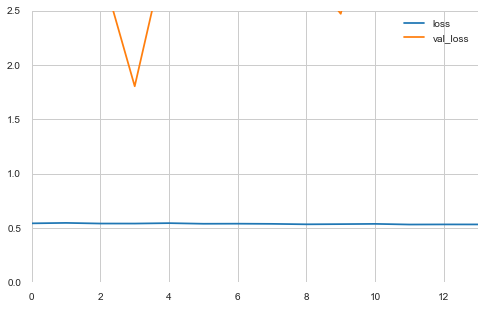

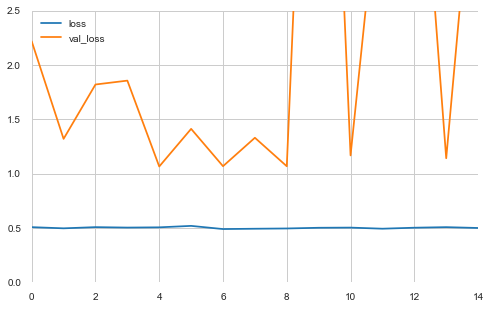

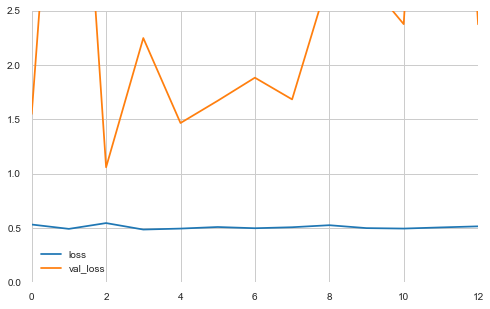

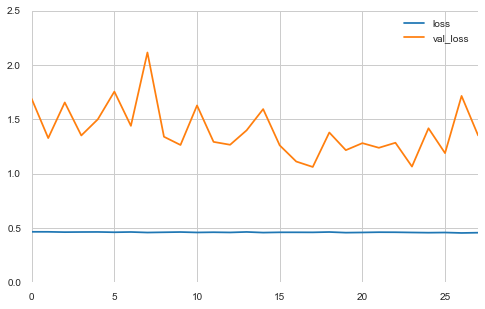

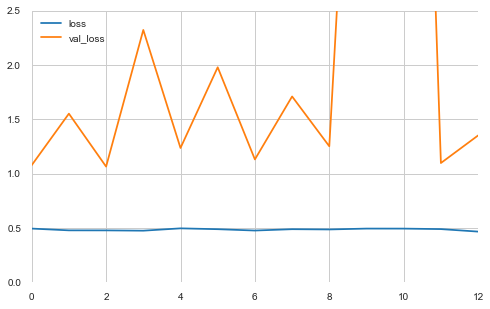

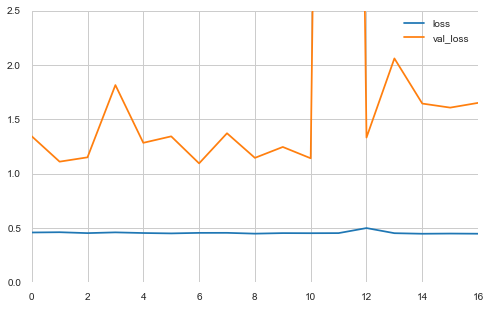

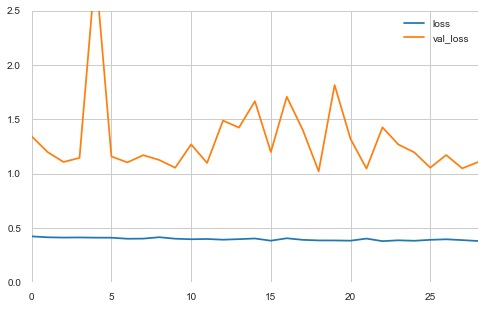

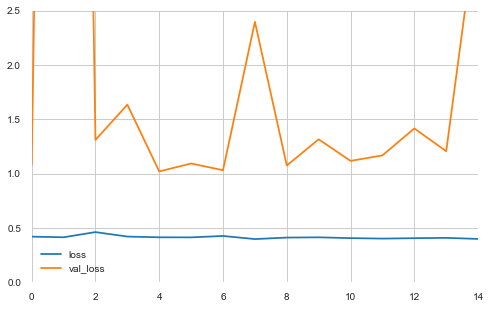

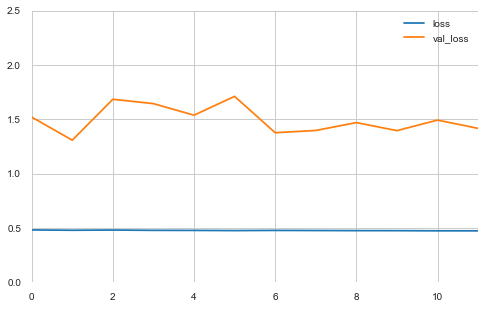

In [265]:
train_test_dfs = split_data_by_date('2018-11-03 23:00:00', X_train_2, y_train_2)
X_train = train_test_dfs.get('X_train')
X_val = train_test_dfs.get('X_test')
y_train = train_test_dfs.get('y_train')
y_val = train_test_dfs.get('y_test')

for k_best_features in range(1,10):
    print('------- k_best_features = {} ------'.format(k_best_features))
    
    drop_lst = ['ID','Time','U','V']
    pre_process = ColumnTransformer(remainder = 'passthrough',
                                    transformers = [(
                                        'drop_columns', 'drop', drop_lst)
                                    ])

    tt = Pipeline(steps=[
        ('powertransformer', PowerTransformer(method='yeo-johnson', standardize=True)),
        # ('normalization', MinMaxScaler(feature_range=(0, 1))) 
        # ('standard_scaler', StandardScaler())
    ])

    prepare_data_pipeline = Pipeline(steps=[
        ('attr_adder', dtr.NewFeaturesAdder(add_time_feat=True, add_cycl_feat=True, add_inv_T=False)), 
        ('pre_processing', pre_process),
        ('powertransformer', PowerTransformer(method='yeo-johnson', standardize=True)),
        # ('normalization', MinMaxScaler(feature_range=(0, 1)),
        # ('standard_scaler', StandardScaler())    
    ])

    X_train_pped = prepare_data_pipeline.fit_transform(X_train)
    X_val_pped = prepare_data_pipeline.transform(X_val)
    X_test_pped = prepare_data_pipeline.transform(X_test_2)

    feature_sel = True
    feature_names = X_train.drop(drop_lst, axis=1).columns

    # Feature selection 
    if feature_sel: 
        ## using Mutual Information
        selec_k_best = SelectKBest(mutual_info_regression, k=k_best_features)
        selec_k_best.fit(X_train_pped, y_train)
        X_train_pped = selec_k_best.transform(X_train_pped)
        X_test_pped = selec_k_best.transform(X_test_pped)
        X_val_pped = selec_k_best.transform(X_val_pped)

        mask =selec_k_best.get_support() #list of booleans
        selected_feat = [] 

        for bool, feature in zip(mask, feature_names):
            if bool:
                selected_feat.append(feature)

    
    # make scorers
    cape_scorer = make_scorer(metric.get_cape, greater_is_better=False)
    
    param_grid = {
        'n_hidden': [1, 3, 5, 7],
        'n_neurons': [10 100, 1000]
        'learning_rate': [e-6, e-4, e-2],
        'input_shape': X_train_pped.shape[1:]
    }
    
    keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)
    
    experiment_name = 'WF1: ANN'
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run():
        grid_search = GridSearchCV(
            keras_reg, 
            param_grid, 
            scoring = cape_scorer
            cv=TimeSeriesSplit(n_splits=5),
            n_jobs=-1
        )

        grid_search.fit(X_train_pped, y_train.to_numpy().reshape(-1,1), epochs=100,
                        validation_data=(X_val_pped, y_val.to_numpy().reshape(-1,1)),
                        callbacks=[keras.callbacks.EarlyStopping(patience=10)] 
                        )

        best_model = grid_search.best_estimator_.model

        # re-training with the best model parameters
        history = best_model.fit(X_train_pped, y_train.to_numpy().reshape(-1,1), epochs=100, 
                       validation_data=(X_val_pped, y_val.to_numpy().reshape(-1,1)),
                       callbacks=[keras.callbacks.EarlyStopping(patience=10)])
        
        # plotting learning curves
        pd.DataFrame(history.history).plot(figsize=(8, 5))
        plt.grid(True)
        plt.gca().set_ylim(0, 2.5)
        plt.show

        # evaluate on test set
        # mse_test = best_model.evaluate(X_test_pped, y_test_2.to_numpy().reshape(-1,1))

        # predict
        predictions = best_model.predict(X_test_pped)

        # Building prediction matrix (ID,Production)
        pred_matrix = np.stack((np.array(y_test_2.index.to_series()).reshape(-1,1), predictions), axis=-1)
        df_pred = pd.DataFrame(data=pred_matrix.reshape(-1,2), columns=['ID','Production'])

        print('Test CAPE: ', metric.get_cape(y_test_2.to_numpy().reshape(-1), predictions.reshape(-1)))
        print('Test rmse: ', np.sqrt(mean_squared_error(y_test_2, predictions)))
        print('Test R2: ', r2_score(y_test_2, predictions))

        ### MLFlow logging ####
        (rmse, mae, r2, cape) = eval_metrics(y_test_2.to_numpy().reshape(-1), predictions.reshape(-1))

        mlflow.set_tag("grid_searh_best_params", grid_search.best_params_)

        # pre-processing
        mlflow.log_param("clean_outliers", clean_outliers)
        mlflow.log_param("feature_selection", feature_sel)
        mlflow.log_param("selected_features", selected_feat)
        mlflow.log_param("k_best_features", k_best_features)

        # grid search parameters
        mlflow.log_param("n_hidden", param_grid.get("n_hidden"))
        mlflow.log_param("n_neuron", param_grid.get("n_neuron"))
        mlflow.log_param("learning_rate", param_grid.get("learning_rate"))

        # metrics
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("cape", cape)

        # artifacts
        # mlflow.sklearn.log_model(best_model, "ANN")
        # mlflow.log_artifact()



In [120]:
y_pred = best_model.predict(X_test_pped)

In [121]:
metric.get_cape(y_test_2, y_pred.reshape(-1))

22.7101543354326

<function matplotlib.pyplot.show(*args, **kw)>

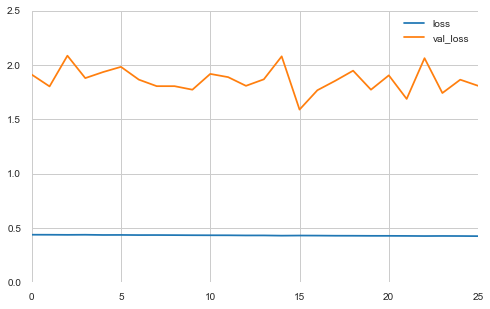

In [119]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,2.5)
plt.show